<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Outline" data-toc-modified-id="Chapter-Outline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter Outline</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Read-in-the-data" data-toc-modified-id="Read-in-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read in the data</a></span></li><li><span><a href="#Calculate-Performance" data-toc-modified-id="Calculate-Performance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate Performance</a></span></li><li><span><a href="#Evaluate-Performance" data-toc-modified-id="Evaluate-Performance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluate Performance</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

In [26]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

# import standard libs
from pathlib import Path
import sys
import time
import os
from copy import copy

# get project dir
pp = Path(Path.cwd()).parts[:-1]
pdir = Path(*pp)
data_dir = pdir/'data'
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from arch import arch_model
from numba import jit
import monthly_returns_heatmap as mrh
import math
import ffn

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns
savefig_kwds=dict(dpi=300, bbox_inches='tight')

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set globals
plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Bitstream Vera Sans'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7

blue, gold, green, red, purple, brown = sns.color_palette('colorblind', 6)
nanex_colors = ("#f92b20", "#fe701b", "#facd1f", "#d6fd1c", "#65fe1b",
                "#1bfe42", "#1cfdb4", "#1fb9fa", "#1e71fb", "#261cfd")
nanex_cmap = mpl.colors.ListedColormap(nanex_colors,name='nanex_cmap')
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-01-04T17:15:45-07:00

CPython 3.7.1
IPython 6.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.19.11-041911-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas 0.23.4
pandas_datareader 0.7.0
numpy 1.15.4
sklearn 0.20.2
statsmodels 0.9.0
scipy 1.1.0
matplotlib 3.0.2
seaborn 0.9.0
plotnine 0.5.1


## Chapter Outline

1. Introduction
2. Import algorithm backtest data
3. Evaluate algorithm results
4. Conclusions
5. Resource and Citations

## Introduction

After learning that the Gaussian Mixture Model and the historical VAR models were relatively effective in forecasting VAR I  decided to test an inverse VAR portfolio allocation algorithm verse some common benchmarks. 

The symbol universe consisted of the following ETFs:

_"QQQ", "DIA", "TLT", "GLD", "EFA", "EEM", 'BND', 'VNQ'_

All the algorithms start from October 1st, 2007 and run until 12/31/2018. They all rebalance monthly to their target weights with a 5% corridor (to minimize transaction costs). 

The benchmark algorithms are the equal weight and 60/40 SPY/BND algorithm. 

I tested 2 Historical VAR models. One with a lookback of 252 days and the other with a lookback 60 days. 

I tested 2 GMM VAR models. One with a lookback of 252 days and the other, 60 days. I restricted the model to 2 components.

## Read in the data

In [6]:
def read_bt_json(fp):
    """fn: read Quantconnect backtest json"""
    with open(fp, encoding='utf-8') as f_in:
        return(json.load(f_in))
    
    
def extract_portfolio_equity(jdata):
    """fn: extract port equity timeseries from Quantconnect json"""
    d = jdata['Charts']['Strategy Equity']['Series']['Equity']['Values']
    equity = (pd.DataFrame(d)
              .rename(columns=dict(x='time', y='equity'))
              .assign(time=lambda df: pd.to_datetime(df.time, utc=True, unit='s'))
              .set_index('time'))
    return equity

def _get_column_name(text):
    """fn: to get column name as first text group"""
    #n = 4 # hardcoded based on fn structure
    groups = text.split('.')
    return '_'.join(groups[:-1])

def read_port_equity(dir_, fn):
    fp = Path(dir_ / fn)#.as_posix()
    jdata = read_bt_json(fp) 
    
    # get column name
    col = _get_column_name(fn)
    # extract equity data
    equity = (extract_portfolio_equity(jdata)
              .rename(columns=dict(equity=col)))
    return equity

In [9]:
filenames = ['equal_weight_benchmark','60_40_benchmark','gmm2_60','gmm2_252',
             'historical_60','historical_252']

dfs = [read_port_equity(Path(pdir/'data'),f'{fn}.json') for fn in filenames]
df = pd.concat(dfs,axis=1).sort_index().dropna().drop_duplicates()
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           equal_weight_benchmark  60_40_benchmark  \
time                                                                 
2018-12-27 15:11:00+00:00            186,566.0730     186,179.4846   
2018-12-27 21:00:00+00:00            189,237.0130     189,082.6596   
2018-12-28 15:51:00+00:00            189,629.5750     189,062.9196   
2018-12-28 21:00:00+00:00            189,758.3280     189,107.1846   
2018-12-31 21:00:00+00:00            189,757.3280     189,107.1846   

                               gmm2_60     gmm2_252  historical_60  \
time                                                                 
2018-12-27 15:11:00+00:00 186,046.8031 177,974.8714   185,910.7374   
2018-12-27 21:00:00+00:00 187,099.1781 179,187.3314   186,821.0024   
2018-12-28 15:51:00+00:00 187,527.9281 179,568.

## Calculate Performance

In [10]:
perf = ffn.calc_stats(df)

## Evaluate Performance

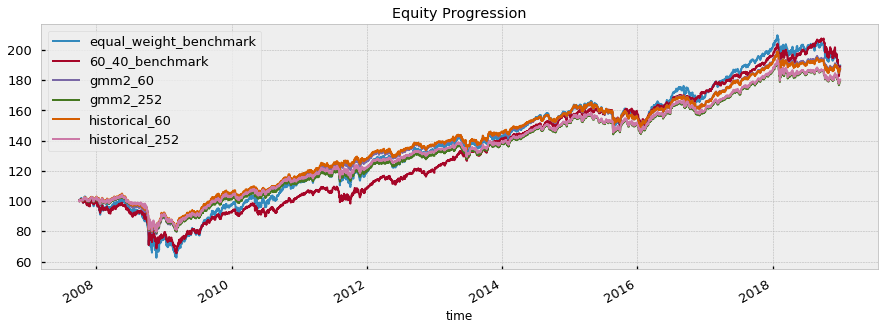

In [12]:
perf.plot()

In [11]:
perf.display()

Stat                 equal_weight_benchmark    60_40_benchmark    gmm2_60     gmm2_252    historical_60    historical_252
-------------------  ------------------------  -----------------  ----------  ----------  ---------------  ----------------
Start                2007-10-01                2007-10-01         2007-10-01  2007-10-01  2007-10-01       2007-10-01
End                  2018-12-31                2018-12-31         2018-12-31  2018-12-31  2018-12-31       2018-12-31
Risk-free rate       0.00%                     0.00%              0.00%       0.00%       0.00%            0.00%

Total Return         89.76%                    89.11%             87.72%      79.74%      87.43%           80.47%
Daily Sharpe         0.46                      0.55               0.69        0.64        0.71             0.66
Daily Sortino        0.73                      0.86               1.12        1.04        1.15             1.07
CAGR                 5.79%                     5.77%              

In [13]:
ffn.calc_max_drawdown(df)

equal_weight_benchmark   -0.3940
60_40_benchmark          -0.3543
gmm2_60                  -0.2492
gmm2_252                 -0.2406
historical_60            -0.2385
historical_252           -0.2373
dtype: float64

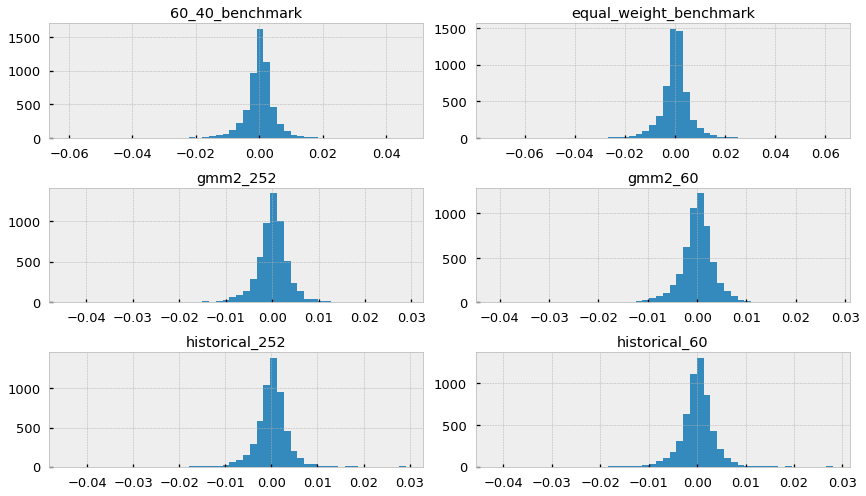

In [17]:
returns = df.to_log_returns().dropna()
returns.hist(figsize=(12,7), bins=50);
plt.tight_layout()

In [20]:
perf['historical_60'].display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep     Oct    Nov    Dec    YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------  -----  -----  -----
  2007   0      0      0      0      0      0      0      0      0       1.95  -0.28   0.17   1.84
  2008  -0.65  -0.42  -0.1    1.73   0.24  -4.17  -0.56  -0.39  -3.98  -10.84   2.41   7.82  -9.56
  2009  -6.51  -3.22   4.56   3.64   3.04  -0.52   4.48   2.29   3.09   -0.72   4.4   -1.03  13.59
  2010  -1.72   1.56   2.4    1.71  -2.43   0.02   2.07   1.19   3       1.72  -0.93   2.68  11.67
  2011   0.39   2.49   0.22   3.64  -0.05  -1.37   1.4    0.75  -1.98    3.41  -0.1    0.08   9.08
  2012   3.07   0.96   0.53   0.4   -3.02   2.23   1.33   0.92   1.14   -1.44   0.54   0.72   7.46
  2013   1.04   0.01   1.28   1.91  -2.2   -2.56   2.44  -1.72   2.59    2.75   0.18   0.57   6.26
  2014  -0.64   2.77  -0.14   1.07   1.59   0.99  -0.69   2.44  -2.39    1.63   1.35   0.12   8.28
  2015   2

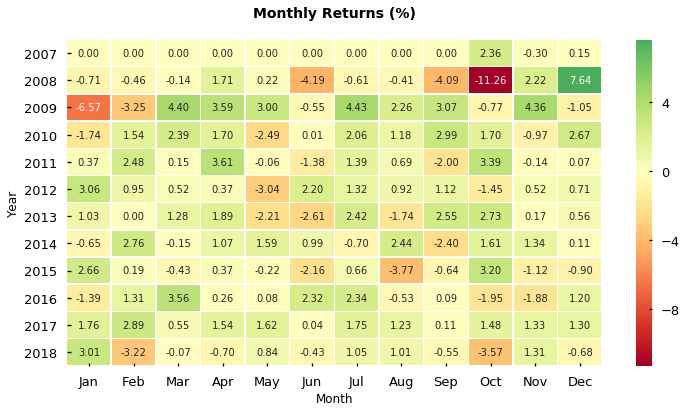

In [25]:
plt.figure(figsize=(12,10))
mrh.plot(returns['historical_60'])

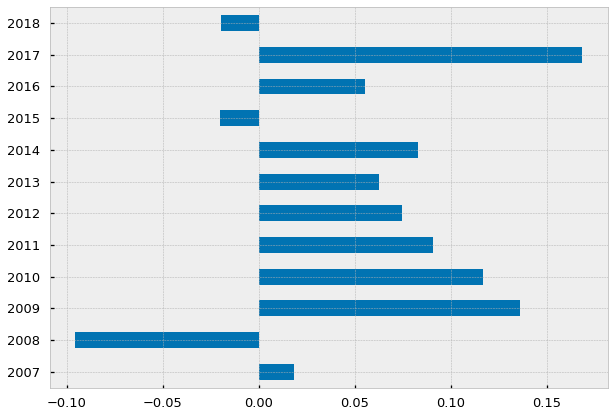

In [35]:
perf['historical_60'].return_table['YTD'].plot.barh(color=blue)

## Conclusions

The `historical_60` algorithm is the winner on a risk-adjusted basis as it has the highest daily, monthly, and yearly sharpe ratios. It also has a low max drawdown and the highest calmar which factors drawdown into the ratio. Next up is the `gmm2_60` which is the runner up on daily, monthly, yearly sharpe ratios, as well as the calmar ratio.

,equal_weight_benchmark,60_40_benchmark,gmm2_60,gmm2_252,historical_60,historical_252
start,2007-10-01 04:00:00+00:00,2007-10-01 04:00:00+00:00,2007-10-01 04:00:00+00:00,2007-10-01 04:00:00+00:00,2007-10-01 04:00:00+00:00,2007-10-01 04:00:00+00:00
end,2018-12-31 21:00:00+00:00,2018-12-31 21:00:00+00:00,2018-12-31 21:00:00+00:00,2018-12-31 21:00:00+00:00,2018-12-31 21:00:00+00:00,2018-12-31 21:00:00+00:00
rf,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
total_return,0.8976,0.8911,0.8772,0.7974,0.8743,0.8047
cagr,0.0579,0.0577,0.0571,0.0530,0.0570,0.0534
max_drawdown,-0.3940,-0.3530,-0.2483,-0.2397,-0.2375,-0.2364
calmar,0.1468,0.1635,0.2301,0.2211,0.2402,0.2261
mtd,-0.0423,-0.0552,-0.0098,-0.0159,-0.0066,-0.0142
three_month,-0.0700,-0.0856,-0.0334,-0.0353,-0.0290,-0.0336
six_month,-0.0504,-0.0438,-0.0180,-0.0231,-0.0142,-0.0229
